<a href="https://colab.research.google.com/github/quinn-dougherty/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=133.39703584853393, mobile=True), User(purchased=False, time_on_site=522.0095650366947, mobile=False), User(purchased=False, time_on_site=184.28714815720156, mobile=True), User(purchased=False, time_on_site=206.44643884169082, mobile=True), User(purchased=False, time_on_site=9.485044656665849, mobile=True), User(purchased=False, time_on_site=447.67009349365355, mobile=False), User(purchased=False, time_on_site=107.05040140771352, mobile=True), User(purchased=False, time_on_site=562.5117001725141, mobile=False), User(purchased=False, time_on_site=239.09108626365784, mobile=True), User(purchased=False, time_on_site=117.5308924612511, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,133.397036,True
1,False,522.009565,False
2,False,184.287148,True
3,False,206.446439,True
4,False,9.485045,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,6.518826808674177,7.6476913285176575,8.224586040981992,9.29946243513536,9.394364630366294,9.485044656665849,9.662050265417134,9.704238003718608,9.966786467848316,10.342899157826556,...,580.9757789455816,581.699331499886,584.3469611988066,587.4123292195668,593.3361405215924,595.7101768371659,596.5233832081707,598.0965158385084,598.5164850820182,599.5503362471342
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,1,1,1,1
True,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.926, 125.125]","(125.125, 243.731]","(243.731, 362.338]","(362.338, 480.944]","(480.944, 599.55]"
purchased,,,,,
False,287,290,155,45,48
True,75,64,30,3,3


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.926, 125.125]","(125.125, 243.731]","(243.731, 362.338]","(362.338, 480.944]","(480.944, 599.55]"
purchased,,,,,
False,0.792818,0.819209,0.837838,0.9375,0.941176
True,0.207182,0.180791,0.162162,0.0625,0.058824


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.904,0.798667
True,0.096,0.201333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
!ls "/content/gdrive/My Drive/"

url = "/content/gdrive/My Drive/persons.csv"

# urlPart1 = "https://github.com/quinn-dougherty/DS-Sprint-01-Dealing-With-Data/"
# urlPart2 = "blob/master/module4-databackedassertions/persons.csv"
# url = urlPart1 + urlPart2

headers = ['id', 'age', 'weight', 'exercise time']

df = pd.read_table(url, sep=',')

df.head()

df.describe()

persons.csv


,id,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


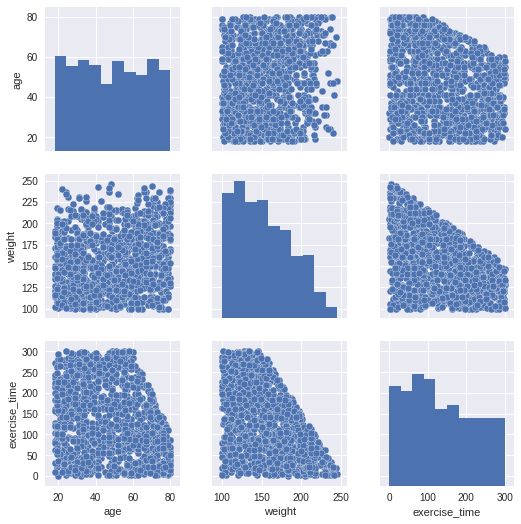

In [16]:
sns.pairplot(df.drop('id', axis=1));

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


# Question 1.
Each of the four features are of type int. ID (the first feature) really doesn't matter, because it's just the same as the index. Doesn't give information. 

# Question 2

Everything seems to have a sort of negative correlation. 

While weight-exerciseTime are a **confounding** or **misleading** relationship, age-exerciseTime looks legit, because the distribution of ages is more roughly uniform than the distribution of anything else. 

Let's look at sns.LinearModel

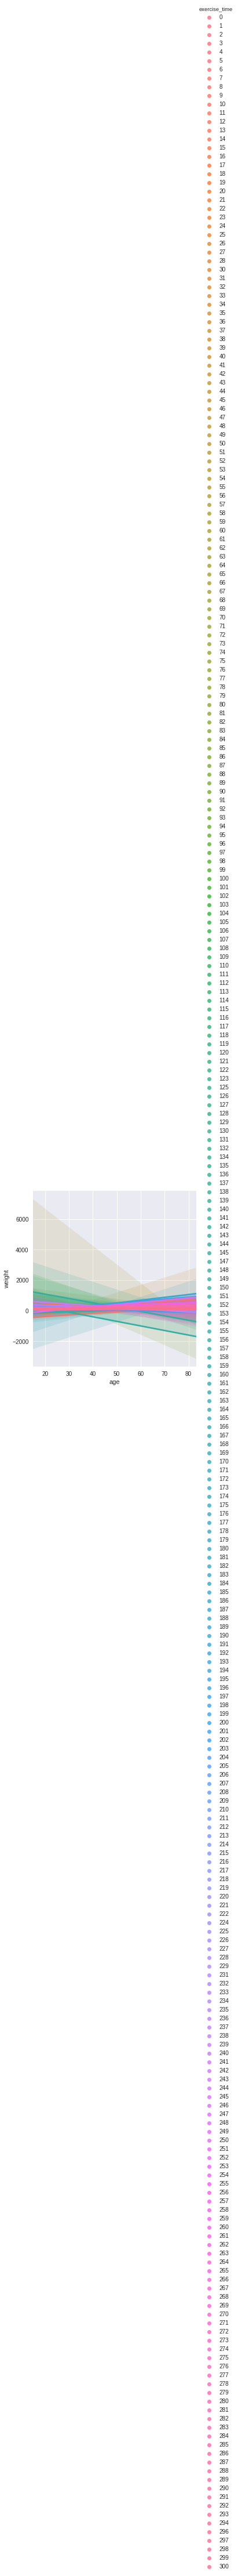

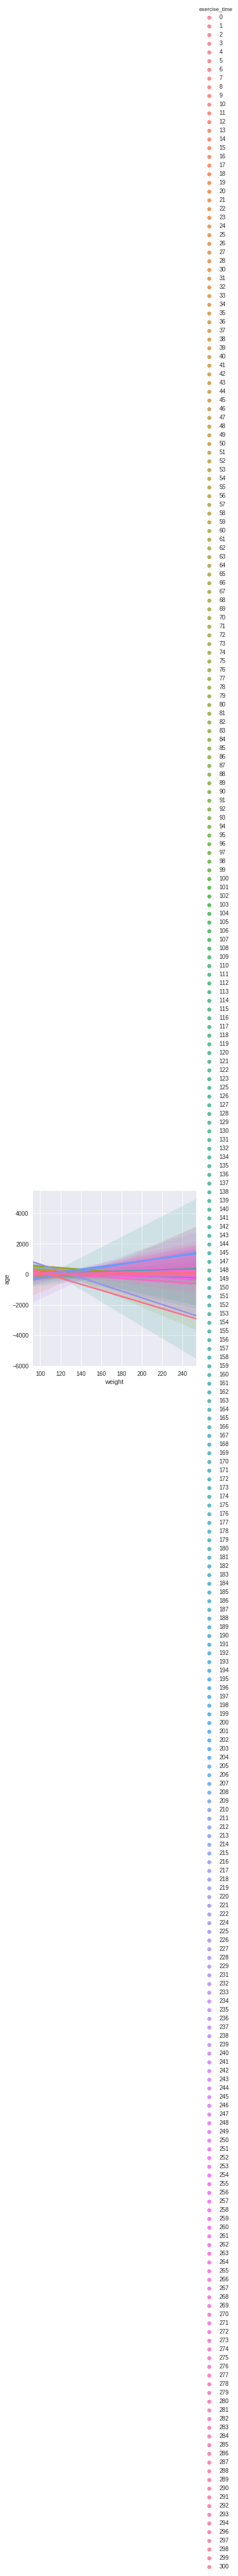

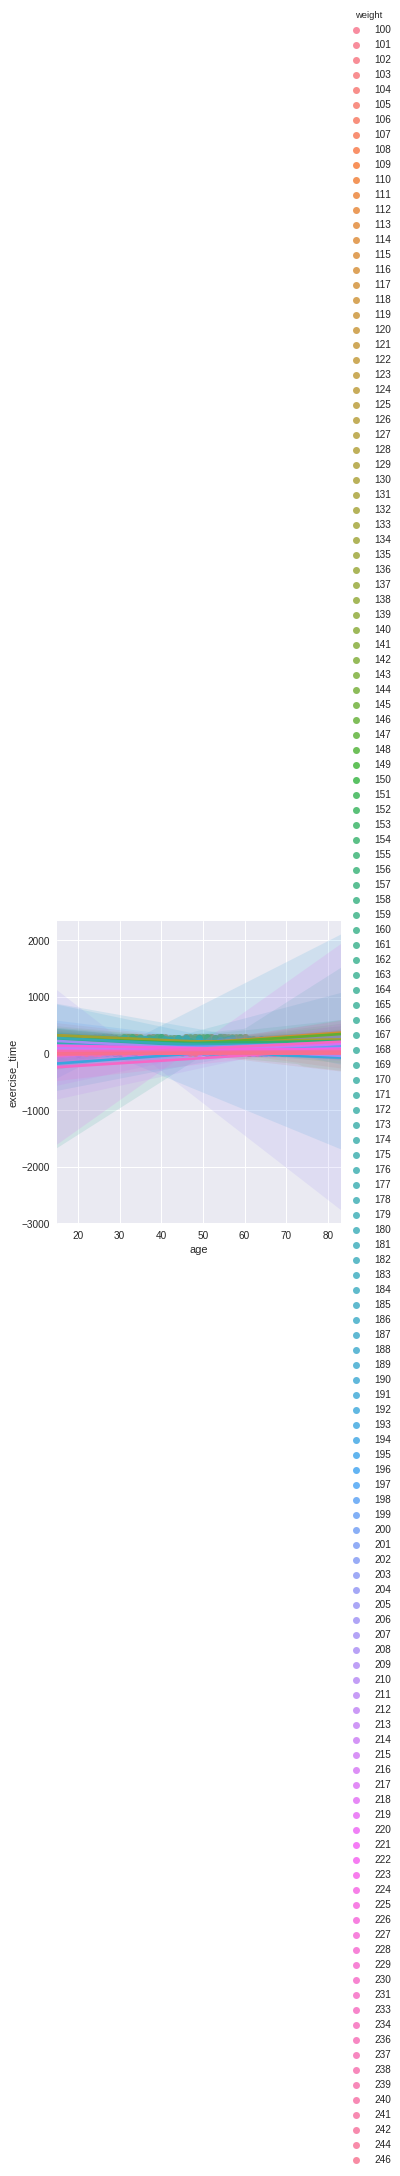

In [23]:
sns.lmplot(x='age', y='weight', data=df, hue='exercise_time');
sns.lmplot(x='weight', y='age', data=df, hue='exercise_time');
sns.lmplot(x='age', y='exercise_time', data=df, hue='weight');

# Question 3

The stark negative correlation of weight and exercise time, that the heaviest people are exercising the least, looks *spurious* when you look at the frequency of the sample. the barplot representing frequencies of people as weight goes up has almost the exact same "slope" (if you'd fit a line) as the scatter between weight and exercise time! 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)